In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [52]:
data = pd.read_excel('C:/Users/michelj8/Documents/Github/data_sets/farm_gdp.xls', sheet_name = 'data')
data = data.query('observation_date < 2020 & observation_date > 1959')
data = data.dropna().reset_index()
data.head()

,index,observation_date,B359RC1Q027SBEA
0,49,1959-04-01,16.939
1,50,1959-07-01,16.715
2,51,1959-10-01,17.561
3,52,1960-01-01,17.014
4,53,1960-04-01,17.973


<ipython-input-22-7efa8102a021>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['log'] = np.log(ts['level'])


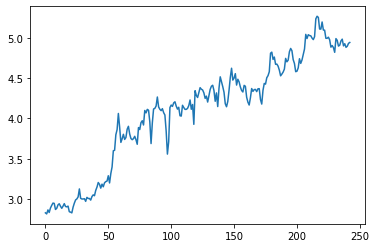

In [22]:
ts = data[['B359RC1Q027SBEA']]
ts.columns = ['level']
ts['log'] = np.log(ts['level'])
ts['log'].plot()

# Build Models

# 1-step ahead AR(1) iterated

In [23]:
ts['log_dif'] = ts['log'].diff(1)
ts['4_ldif'] = ts['log'].diff(4)
ts = ts.dropna()

In [24]:
#Fit 1-step model
arma_model = ARIMA(ts['log_dif'], order=(1, 0, 0)).fit()
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                log_dif   No. Observations:                  239
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 228.372
Date:                Mon, 19 Oct 2020   AIC                           -450.743
Time:                        13:14:09   BIC                           -440.314
Sample:                             0   HQIC                          -446.540
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.006      1.400      0.162      -0.004       0.021
ar.L1         -0.0090      0.045     -0.201      0.840      -0.096       0.078
sigma2         0.0087      0.001     16.931      0.0

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [25]:
omega, rho, sigsq =  arma_model.params

year_mean = np.sum([omega*(4-i)*rho**i for i in range(0,4)])
year_rho = np.sum([rho**i for i in range(1,5)])
year_var = sigsq*np.sum( [  np.square(np.sum([rho**i for i in range(0,k)])) for k in range(1,5)])

In [26]:
ts['ar_4step_pred'] =  ( year_mean + year_rho*ts['log_dif']) + ts['log']
ts['ar_4step_pred'] = ts['ar_4step_pred'].shift(4)
ts

,level,log,log_dif,4_ldif,ar_4step_pred
4,17.973,2.888871,0.054834,0.059252,NaN
5,18.578,2.921978,0.033107,0.105672,NaN
6,19.118,2.950630,0.028652,0.084950,NaN
7,19.048,2.946962,-0.003668,0.112926,NaN
8,17.658,2.871189,-0.075773,-0.017682,2.923414
...,...,...,...,...,...
238,137.947,4.926870,0.026622,0.018799,4.943010
239,131.887,4.881945,-0.044924,-0.079668,4.996168
240,133.749,4.895965,0.014019,-0.087580,5.018382
241,138.616,4.931708,0.035743,0.031460,4.936020


6.8226031199975665

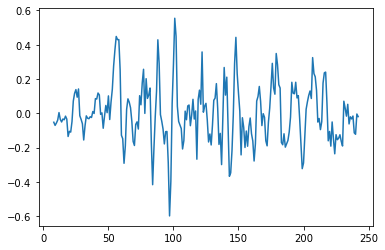

In [27]:
(ts['log']-ts['ar_4step_pred']).plot()
np.square((ts['log']-ts['ar_4step_pred'])).sum()

# "Direct Forecast" 

In [28]:
reg_df = ts[['4_ldif']]
reg_df[['year_lag']] = reg_df[['4_ldif']].shift(4)
reg_df = reg_df.dropna()

X = reg_df['year_lag'].values
Y = reg_df['4_ldif'].values
X = sm.add_constant(X)
direct_model = sm.OLS(Y,X)
results = direct_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     26.28
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           6.21e-07
Time:                        13:14:17   Log-Likelihood:                 94.812
No. Observations:                 235   AIC:                            -185.6
Df Residuals:                     233   BIC:                            -178.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0452      0.011      4.180      0.0

C:\Users\michelj8\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [29]:
ts['4_ldif'] 

4      0.059252
5      0.105672
6      0.084950
7      0.112926
8     -0.017682
         ...   
238    0.018799
239   -0.079668
240   -0.087580
241    0.031460
242    0.015266
Name: 4_ldif, Length: 239, dtype: float64

In [30]:
alpha,beta = results.params
direct_sigsq = np.mean(np.square(results.resid))

ts['direct_pred'] = alpha + beta *ts['4_ldif']+ts['log']
ts['direct_pred'] = ts['direct_pred'].shift(4)

In [31]:
direct_sigsq

0.02612703594151887

6.139853446256933

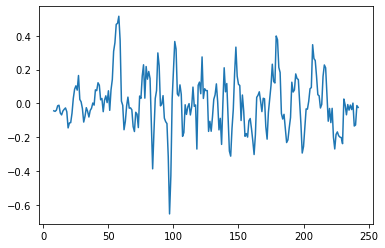

In [32]:
(ts['log']-ts['direct_pred']).plot()
np.square((ts['log']-ts['direct_pred'])).sum()

In [33]:
ts = ts.dropna()
ts['indirect_debias'] = ts['ar_4step_pred'] + (ts['log'] - ts['ar_4step_pred'] ).mean()
ts

<ipython-input-33-a45278bb29e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['indirect_debias'] = ts['ar_4step_pred'] + (ts['log'] - ts['ar_4step_pred'] ).mean()


,level,log,log_dif,4_ldif,ar_4step_pred,direct_pred,indirect_debias
8,17.658,2.871189,-0.075773,-0.017682,2.923414,2.915217,2.922263
9,17.925,2.886196,0.015007,-0.035782,2.956715,2.933531,2.955564
10,18.699,2.928470,0.042274,-0.022160,2.985407,2.968787,2.984256
11,18.958,2.942226,0.013756,-0.004736,2.982027,2.956203,2.980875
12,18.373,2.910882,-0.031344,0.039693,2.906895,2.922052,2.905744
...,...,...,...,...,...,...,...
238,137.947,4.926870,0.026622,0.018799,4.943010,4.925323,4.941859
239,131.887,4.881945,-0.044924,-0.079668,4.996168,5.015991,4.995017
240,133.749,4.895965,0.014019,-0.087580,5.018382,5.024127,5.017230
241,138.616,4.931708,0.035743,0.031460,4.936020,4.944647,4.934869


Text(0.5, 1.0, 'Residuals values')

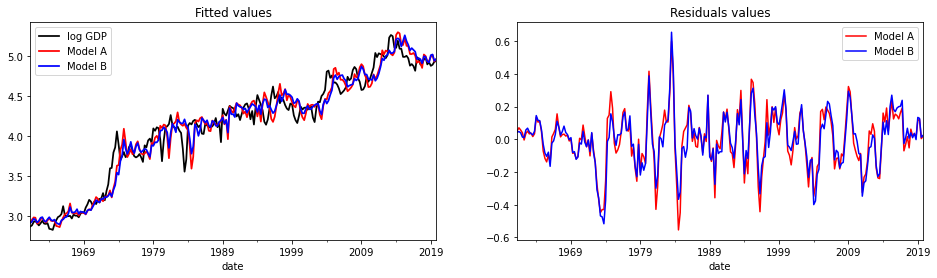

In [34]:
plot_ts = ts.copy()
plot_ts['date']= data.loc[8:]['observation_date']
plot_ts = plot_ts.set_index('date')
fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))

plot_ts[['log','ar_4step_pred','direct_pred']].plot(ax = axa, linewidth = 1.75, color = ['black','red','blue'])
axa.legend(['log GDP','Model A', 'Model B'])
axa.set_title('Fitted values')

plot_ts[['ar_4step_pred','direct_pred']].subtract(plot_ts['log'],axis= 0).plot(ax = axb, color = ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Residuals values')

# Compare Forecasts

# KS test for PITS

In [37]:
indirect_pits = []
direct_pits = []
# indirect_debias_pits = []

for time in ts.index:
    actual = ts.loc[time,'log']
    
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    
#     indirect_bias = ts.loc[time,'indirect_debias']
    
    indirect_pits.append(scipy.stats.norm.cdf(actual, loc=ar_mean, scale=ar_std) )
    direct_pits.append(scipy.stats.norm.cdf(actual, loc=direct_mean, scale=direct_std) )
#     indirect_debias_pits.append(scipy.stats.norm.cdf(actual, loc=indirect_bias, scale=ar_std) )
    
print(stats.kstest(indirect_pits, 'uniform'))
print(stats.kstest(direct_pits, 'uniform'))
# print(stats.kstest(indirect_debias_pits, 'uniform'))

KstestResult(statistic=0.07118223308803151, pvalue=0.17606489592933983)
KstestResult(statistic=0.0643495363861546, pvalue=0.27295215276657137)


# KL Divergence

In [38]:
indirect_kl = 0
direct_kl = 0
# indirect_debias_kl = 0


for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    
#     indirect_bias = ts.loc[time,'indirect_debias']

    indirect_kl = indirect_kl + scipy.stats.norm.logpdf(actual, loc=ar_mean, scale=ar_std)
    direct_kl = direct_kl + scipy.stats.norm.logpdf(actual, loc=direct_mean, scale=direct_std)
#     indirect_debias_kl = indirect_debias_kl + scipy.stats.norm.logpdf(actual, loc=indirect_bias, scale=ar_std)

    
print(indirect_kl)
print(direct_kl)
# print(indirect_debias_kl)

80.93791685181498
94.81164000943933


# Coverage of all confidence intervals

In [39]:
coverage_df = pd.DataFrame(columns = ['prob','indirect_ar_pct', 'direct_pct']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    coverage_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    
#     indirect_bias = ts.loc[time,'indirect_debias']

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
        ar_debias_ci = scipy.stats.norm.interval(prob, loc=indirect_bias, scale=ar_std)
        
        
        coverage_df.loc[prob] = coverage_df.loc[prob] + [1*(actual > ar_ci[0])*(actual<ar_ci[1]),
                                                           1*(actual > direct_ci[0])*(actual<direct_ci[1]) ]
#                                                         1*(actual > ar_debias_ci[0])*(actual<ar_debias_ci[1])]
        
coverage_df = coverage_df.div(len(ts))
coverage_df['theoretical'] = prob_list

Text(0.5, 1.0, 'Scaled empirical Coverage Curve')

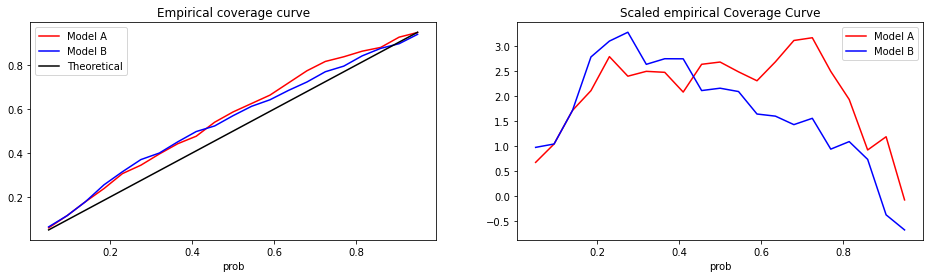

In [40]:
prob_list = coverage_df.index.values

fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))
coverage_df.plot(ax = axa, color =  ['red','blue','black'] )
axa.legend(['Model A', 'Model B', 'Theoretical'])
axa.set_title('Empirical coverage curve')

coverage_df[['indirect_ar_pct','direct_pct']].subtract(prob_list, axis = 0).div(np.sqrt(prob_list*(1-prob_list)), axis = 0).multiply(np.sqrt(len(ts))).plot(ax = axb,color = ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Scaled empirical Coverage Curve')

In [41]:
print(np.square(coverage_df['indirect_ar_pct'] - coverage_df['theoretical']).sum())
print(np.square(coverage_df['direct_pct'] - coverage_df['theoretical']).sum())

0.09101912630149386
0.0700739022181983


# Interval forecast scores

In [42]:
def score(x,lower,upper,prob):
    return (upper-lower) + (2/(1-prob))*(max(x-upper,0) + max(lower-x,0))

In [43]:
score_df = pd.DataFrame(columns = ['prob','indirect_ar_pct', 'direct_pct']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    score_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )

#     indirect_bias = ts.loc[time,'indirect_debias']

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
#         ar_debias_ci = scipy.stats.norm.interval(prob, loc=indirect_bias, scale=ar_std)

        
        score_df.loc[prob] = score_df.loc[prob] + [score(actual, ar_ci[0],ar_ci[1], prob),
                                                   score(actual, direct_ci[0], direct_ci[1], prob) ]
#                                                   score(actual, ar_debias_ci[0],ar_debias_ci[1], prob)]
        
score_df = score_df.div(len(ts))

Text(0.5, 1.0, 'Interval forecast scores')

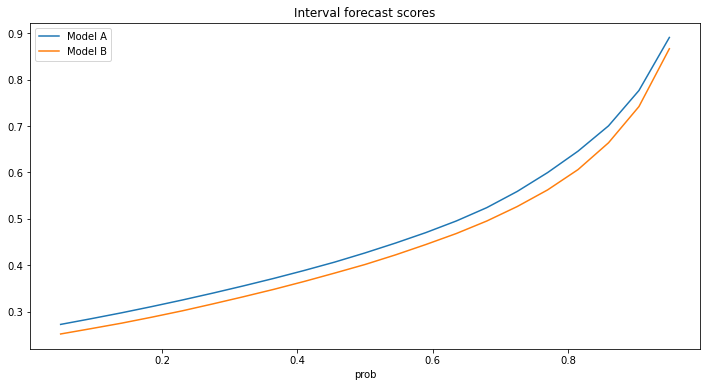

In [44]:
fig, ax = plt.subplots(figsize = (12,6))
score_df.plot(ax = ax)

ax.legend(['Model A','Model B'])
ax.set_title('Interval forecast scores')

In [45]:
print( ar_std, direct_std)

0.1848833990557641 0.16163859669496908


In [46]:
miss_df = pd.DataFrame(columns = ['prob','indirect_miss','indirect_length', 'direct', 'direct_length']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    miss_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
        
        
        miss_df.loc[prob] = miss_df.loc[prob] + [max(actual - ar_ci[1],0) + max(ar_ci[0]-actual,0),
                                                 ar_ci[1]-ar_ci[0],
                                                 max(actual - direct_ci[1],0) + max(direct_ci[0]-actual,0),
                                                 direct_ci[1]-direct_ci[0] ]
        
miss_df = miss_df.div(len(ts))

In [47]:
miss_df

,indirect_miss,indirect_length,direct,direct_length
prob,,,,
0.050,0.118348,0.023187,0.109930,0.020272
0.095,0.108806,0.044131,0.101643,0.038582
0.140,0.099806,0.065217,0.093723,0.057018
0.185,0.091415,0.086518,0.086532,0.075641
0.230,0.083493,0.108111,0.079752,0.094518
0.275,0.076027,0.130078,0.073522,0.113724
0.320,0.068950,0.152515,0.067514,0.133340
0.365,0.062215,0.175529,0.061727,0.153460
0.410,0.055859,0.199244,0.056264,0.174193


Text(0.5, 1.0, 'Aveage length of interval')

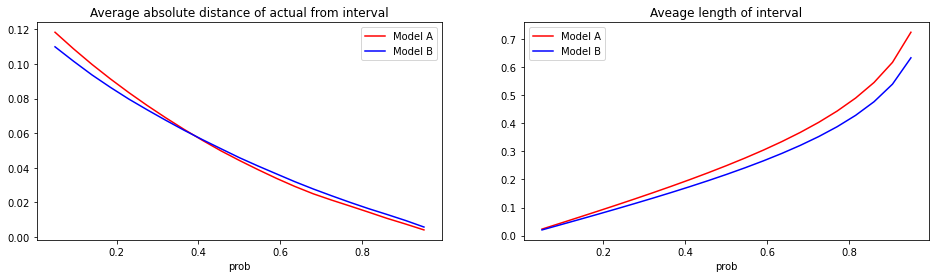

In [48]:
prob_list = coverage_df.index.values

fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))
miss_df[['indirect_miss','direct']].plot(ax = axa, color =  ['red','blue'] )
axa.legend(['Model A', 'Model B'])
axa.set_title('Average absolute distance of actual from interval')

miss_df[['indirect_length','direct_length']].plot(ax = axb, color =  ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Aveage length of interval')